# Import

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
import warnings
import csv
import os

import math # arctangent; math.atan 사용 목적
import statistics

from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as po

from scipy.interpolate import RegularGridInterpolator

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.ticker as ticker
import matplotlib.colors as colors

from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.text import Annotation

from Graph_2D import *

# Load Dataset

In [2]:
working_dir = 'D:/OneDrive - 연세대학교 (Yonsei University)/Projects/2023_SSM_Feasibility/Dataset'

## Data

In [3]:
folder_name = 'Dataset/03_SSM'
folder_dir = os.path.join(working_dir, folder_name)

file_name = 'merging_type1_03frm_0.10sec.csv'
file_path = os.path.join(folder_dir, file_name)

In [4]:
df = pd.read_csv(file_path, encoding = 'cp949')

In [5]:
df.head(3)

,Unnamed: 0.1,Unnamed: 0,Vehicle ID,LV_ID,LV_type,frame,local_x,local_y,V_len,V_wid,...,MDRAC2,DCIA,unsafety,MTC,MMTC,RCRI,TERCRI,CIF,CIF2,ACIF
0,0,0,2,1,LV0,438.0,37.277924,7.726166,4.901581,2.063824,...,NaN,NaN,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN
1,1,0,2,1,LV0,441.0,39.826355,7.785396,4.901581,2.063824,...,NaN,NaN,-10.772776,1.464949,-3.354793,0,0.0,16.239014,NaN,NaN
2,2,0,2,1,LV0,444.0,42.391769,7.882839,4.901581,2.063824,...,NaN,-0.214509,-4.238305,1.443576,-3.295915,1,0.1,17.922971,NaN,135.130178


In [6]:
len(df)

117113

## Threshold

In [115]:
folder_name = 'Documents'
file_name = 'SSM_variables.xlsx'
sheet_name = 'threshold'

threshold_path = os.path.join(working_dir, folder_name, file_name)

In [116]:
threshold_list = np.array(pd.read_excel(threshold_path, sheet_name = sheet_name))

In [117]:
threshold_list[-10:]

array([['TIDRAC', 0.0],
       ['MDRAC', 3.4],
       ['MDRAC2', 3.4],
       ['DCIA', 3.4],
       ['RCRI', 0.999],
       ['TERCRI', 0.0],
       ['unsafety', 0.0],
       ['CIF', nan],
       ['CIF2', nan],
       ['ACIF', nan]], dtype=object)

In [10]:
SSM_list = list(pd.read_excel(threshold_path, sheet_name = sheet_name)['SSM'])

# 적절성에 대한 분석

## Most Danger Point by SSM
* 각 SSM별로 "가장 위험한 지점"을 점으로 나타내기

In [11]:
SSM = 'DRAC'
idx = np.where(threshold_list == SSM)[0][0]
TH = threshold_list[idx][1]
#Vehicle_ID, LV_ID = 5, 4
Vehicle_ID, LV_ID = 1544, 1542
#Vehicle_ID, LV_ID = 13, 12
#Vehicle_ID, LV_ID = 539, 538
#Vehicle_ID, LV_ID = 51, 48
#Vehicle_ID, LV_ID = 419, 417

In [12]:
pair_list = [('Car-following', 5, 4), 
             ('Lanechange', 1544, 1542), 
             ('Parallel', 13, 12), 
             ('Lanechange', 539, 538), 
             ('Parallel', 51, 48), 
             ('Car-following', 419, 417),
             ('Car-following', 37, 34)] # Situation, Vehicle_ID, LV_ID

Text(0, 0.5, 'local_y')

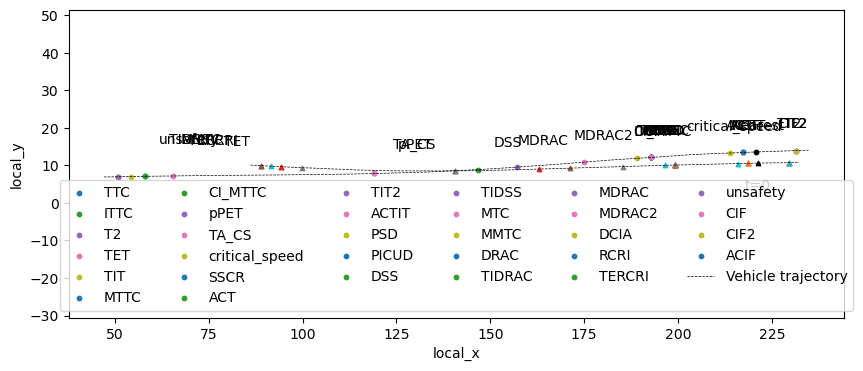

In [13]:
sample = df[(df['Vehicle ID'] == Vehicle_ID) & (df['LV_ID'] == LV_ID)].drop_duplicates(subset = ['Time'])

fig = plt.figure(figsize = (10, 4))
ax = fig.add_subplot()

# V, LV의 각 SSM별 가장 위험한 시점 뽑기

# 시간변수 미리 설정하기
### 가장 두 차량 사이가 가까운 시점을 뽑기 :: 이 시점이 t == 0이 됨
nearest = sample[sample['D'] == sample['D'].min()].iloc[0]
nearest_time = nearest['Time']
nearest_V_x = nearest['local_x']
nearest_V_y = nearest['local_y']
nearest_LV_x = nearest['LV_local_x']
nearest_LV_y = nearest['LV_local_y']

nearest_V_velocity_x = nearest['velocity_x']
nearest_V_velocity_y = nearest['velocity_y']
nearest_LV_velocity_x = nearest['LV_velocity_x']
nearest_LV_velocity_y = nearest['LV_velocity_y']

## 가장 두 차량 사이가 가까웠던 점을 기준으로 V_time 평준화
sample['Time_label'] = sample['Time'] - nearest_time

for SSM in SSM_list:

    if len(sample[SSM].unique()) > 1: # 만약 SSM 컬럼이 NaN 외의 값을 가지고 있다면

        ####### 가장 위험한 순간 ########

        # 가장 위험한 순간의 row 뽑기

        ## 임계값이 높을수록 위험한 경우 
        if SSM in ['TIT', 'TIT2', 'ACTIT', 'TIDRAC', 'TIDSS', 'TERCRI', 'SSCR', 'TET', 'CI_MTTC', 'DRAC', 'MDRAC', 'DCIA', 'SSCR', 'RCRI', 'ITTC']:
            V_time_MD = sample[sample[SSM] == np.nanmax(sample[SSM])]['Time'].iloc[0]
            MD = sample[sample['Time'] == V_time_MD].iloc[0]
            V_time_label_MD = round(sample[sample[SSM] == np.nanmax(sample[SSM])]['Time_label'].iloc[0], 2) # 라벨용 시간은 소숫점 아래 둘째자리까지 나타낸다.

        elif SSM in ['TTC', 'T2', 'MTTC', 'TA', 'ACT', 'PSD', 'pPET', 'PICUD', 'DSS', 'MTC', 'MMTC']:
            V_time_MD = sample[sample[SSM] == np.nanmin(sample[SSM])]['Time'].iloc[0]
            MD = sample[sample['Time'] == V_time_MD].iloc[0]
            V_time_label_MD = round(sample[sample[SSM] == np.nanmin(sample[SSM])]['Time_label'].iloc[0], 2) # 라벨용 시간은 소숫점 아래 둘째자리까지 나타낸다.

        else:
            V_time_MD = sample[sample[SSM] == np.nanmax(sample[SSM])]['Time'].iloc[0]
            MD = sample[sample['Time'] == V_time_MD].iloc[0]
            V_time_label_MD = round(sample[sample[SSM] == np.nanmax(sample[SSM])]['Time_label'].iloc[0], 2) # 라벨용 시간은 소숫점 아래 둘째자리까지 나타낸다.


        SSM_MD = round(MD[SSM], 3)

        ## 차량 꼭지점 뽑기
        local_x = MD['local_x']
        local_y = MD['local_y']
        LV_local_x = MD['LV_local_x']
        LV_local_y = MD['LV_local_y']

        ## 차량 V, 차량 LV의 중앙지점 찍기 : 점 2개
        ax.scatter(local_x, local_y, label = f'{SSM}', s = 10)
        ax.scatter(LV_local_x, LV_local_y, marker = '^', s = 10)


        ## 텍스트 붙이기
        ax.text((local_x+LV_local_x)/2, np.max([local_y, LV_local_y])+6, 
                f'{SSM}', fontsize = 10, 
                va = 'baseline', ha = 'center')

        # ax.text((local_x+LV_local_x)/2, np.max([local_y, LV_local_y])-10, 
        #         f't={V_time_label_MD}', fontsize = 10, 
        #         va = 'baseline', ha = 'center')


####### 가장 가까운 순간 순간 :: Nearest ########

## 차량 중앙지점 찍기
ax.scatter(nearest_V_x, nearest_V_y, color = 'black', s = 10)
ax.scatter(nearest_LV_x, nearest_LV_y, color = 'black', marker = '^', s = 10)

## 텍스트 붙이기
ax.text((nearest_V_x+nearest_LV_x)/2, np.max([nearest_V_y, nearest_LV_y])+6, 
        f'Nearest', fontsize = 10, 
        va = 'baseline', ha = 'center')

ax.text((nearest_V_x+nearest_LV_x)/2, np.max([nearest_V_y, nearest_LV_y])-10, 
        f't=0', fontsize = 10, 
        va = 'baseline', ha = 'center')


## 차량 V, 차량 LV의 궤적을 점선으로 나타내기
ax.plot(sample['local_x'], sample['local_y'], color = 'black', linestyle = '--', linewidth = 0.5, label = 'Vehicle trajectory')
ax.plot(sample['LV_local_x'], sample['LV_local_y'], color = 'black', linestyle = '--', linewidth = 0.5)


# 범례 및 스케일 지정
ax.legend(loc = 'lower center', ncol = len(SSM_list)/5)

ax.set_xlim(0, 250)
ax.set_ylim((np.nanmin([np.nanmin(LV_local_y), np.nanmin(local_y)])-5, np.nanmax([np.nanmax(LV_local_y), np.nanmax(local_y)])+20))
ax.axis('equal')
ax.set_xlabel('local_x')
ax.set_ylabel('local_y')

#plt.show()

## Heatmap
* 전체 자료 분석
* 그 뭐라는 분석 있음 그거

## Most Dangerous Timing
* 전체 자료 분석
* 가장 위험한 시점 타이밍에 대한 및 데이터프레임
* https://syeilendrapramuditya.wordpress.com/2023/01/04/heatmap-plot-of-xyz-data-from-file-with-python-numpy-matplotlib-2d-colored-heatmap/

In [358]:
def heatmap_2d(df, SSM):
    """
    각 SSM에 대해 히트맵 그려주는 함수
    """

    if SSM not in ['D', 'D_x']:
        df2 = df.copy()
        idx = np.where(threshold_list == SSM)[0][0]
        threshold = threshold_list[idx][1]

    else:
        df2 = df.copy()
        df2 = df[df['LV_type'] == 'LV0']

    df2['X'] = df2['local_x'].apply(np.floor)
    df2['Y'] = df2['local_y'].apply(np.floor)

    sample = pd.pivot_table(df2, index = ['X'], columns = ['Y'], values = SSM, aggfunc = np.nanmean)

    x = np.array(df2['X'].unique())
    y = np.array(df2['Y'].unique())

    
    for xi in x:
        if xi not in list(sample.columns):
            sample[xi] = None
            
        else:
            pass
        
    sample = sample.T
    
    for yi in y:
        if yi not in list(sample.columns):
            sample[yi] = None
            
        else:
            pass
        
    sample = sample.T
    z = np.array(sample)
    

    X, Y = np.meshgrid(x, y)
    data = z.T
    
    print(X.shape, Y.shape, data.shape)

    fig = plt.figure(figsize = (9, 3), dpi = 300)
    ax = fig.add_subplot()

    ## 임계값 == 0이고, 임계값보다 크면 클수록 위험한 경우
    if SSM in ['TIT', 'TIT2', 'ACTIT', 'TIDRAC', 'TIDSS', 'TERCRI', 'SSCR', 'TET', 'CI_MTTC']:
        TITnorm = colors.TwoSlopeNorm(vmin = 0, 
                                      vcenter = np.nanmean(sample), 
                                      vmax = np.nanmax([0.5, np.nanmax(sample)]))
        heat = ax.contourf(X, Y, data)

        # heat = ax.imshow(data, 
        #            aspect = 'equal', 
        #            norm = TITnorm,
        #            cmap = 'OrRd',
        #            extent = [min(x), max(x), min(y), max(y)] ) 

    ## 임계값이 존재하고, 값이 0 이상이며, 임계값보다 작을수록 위험한 경우
    elif SSM in ['TTC', 'T2', 'MTTC', 'TA', 'ACT', 'PSD', 'pPET']:
        divnorm = colors.TwoSlopeNorm(vmin = 0, 
                                      vcenter = threshold, 
                                      vmax = 20)

        heat = ax.imshow(data, 
                   aspect = 'equal', 
                   norm = divnorm,
                   cmap = 'RdBu',
                   extent = [min(x), max(x), min(y), max(y)])

    elif SSM in ['PICUD', 'DSS', 'MTC', 'MMTC']:
        divnorm = colors.TwoSlopeNorm(vmin = np.nanmin([-10, np.nanmin(sample)]), vcenter = threshold, vmax = np.nanmax([10, np.nanmax(sample)]))

        heat = ax.imshow(data, 
               aspect = 'equal', 
               norm = divnorm,
               cmap = 'RdBu',
               extent = [min(x), max(x), min(y), max(y)])

    ## 임계값이 있고, 임계값보다 클수록 위험한 경우
    elif SSM in ['DRAC', 'MDRAC', 'DCIA', 'SSCR', 'RCRI', 'ITTC']:
        divnorm = colors.TwoSlopeNorm(vmin = np.nanmin(sample), vcenter = threshold, vmax = threshold + 5)

        heat = ax.imshow(data, 
           aspect = 'equal', 
           norm = divnorm,
           cmap = 'coolwarm',
           extent = [min(x), max(x), min(y), max(y)])

    elif SSM in ['D', 'D_x']:

        TITnorm = colors.TwoSlopeNorm(vmin = 0, 
                                      vcenter = np.nanmean(sample), 
                                      vmax = np.nanmax([0.5, np.nanmax(sample)]))

        heat = ax.imshow(data, 
                   aspect = 'equal', 
                   norm = TITnorm,
                   cmap = 'gist_rainbow',
                   extent = [min(x), max(x), min(y), max(y)] ) 

    else:
        heat = ax.imshow(data, 
           aspect = 'equal', 
           vmin = np.nanmin(sample), vmax = np.nanmax(sample),
           cmap = 'turbo',
           extent = [min(x), max(x), min(y), max(y)])


    ## 차로변경(LC) 위치 찍기
    LC_right = df[(df['Lane_change'] == 'Change') & (df['Lane_change_direction'] == 'Right')]
    LC_left = df[(df['Lane_change'] == 'Change') & (df['Lane_change_direction'] == 'Left')]

    ax.scatter(LC_right['local_x'], LC_right['local_y'], s = 3, c = 'Black', marker = 'o', linewidth = 0.3, label = 'To Right')
    ax.scatter(LC_left['local_x'], LC_left['local_y'], s = 3, c = 'Black', marker = 'x', linewidth = 0.3, label = 'To Left')

    ax.legend(bbox_to_anchor = (1.15, 1.05), fancybox = True)
    ax.set_title(f'{SSM}', fontsize = 12)
    ax.set_xlabel('Direction of vehicles →', fontsize = 10)
    ax.set_ylabel('Y', fontsize = 10)

    fig.colorbar(heat, ax = ax, shrink = 0.2)

    #plt.savefig('test.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

In [344]:
z.T.shape

(1000, 1000)

(21, 216) (21, 216) (236, 226)


C:\Users\User\AppData\Local\Temp\ipykernel_772\1364448051.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sample[xi] = None
C:\Users\User\AppData\Local\Temp\ipykernel_772\1364448051.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sample[xi] = None
C:\Users\User\AppData\Local\Temp\ipykernel_772\1364448051.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) ins

TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

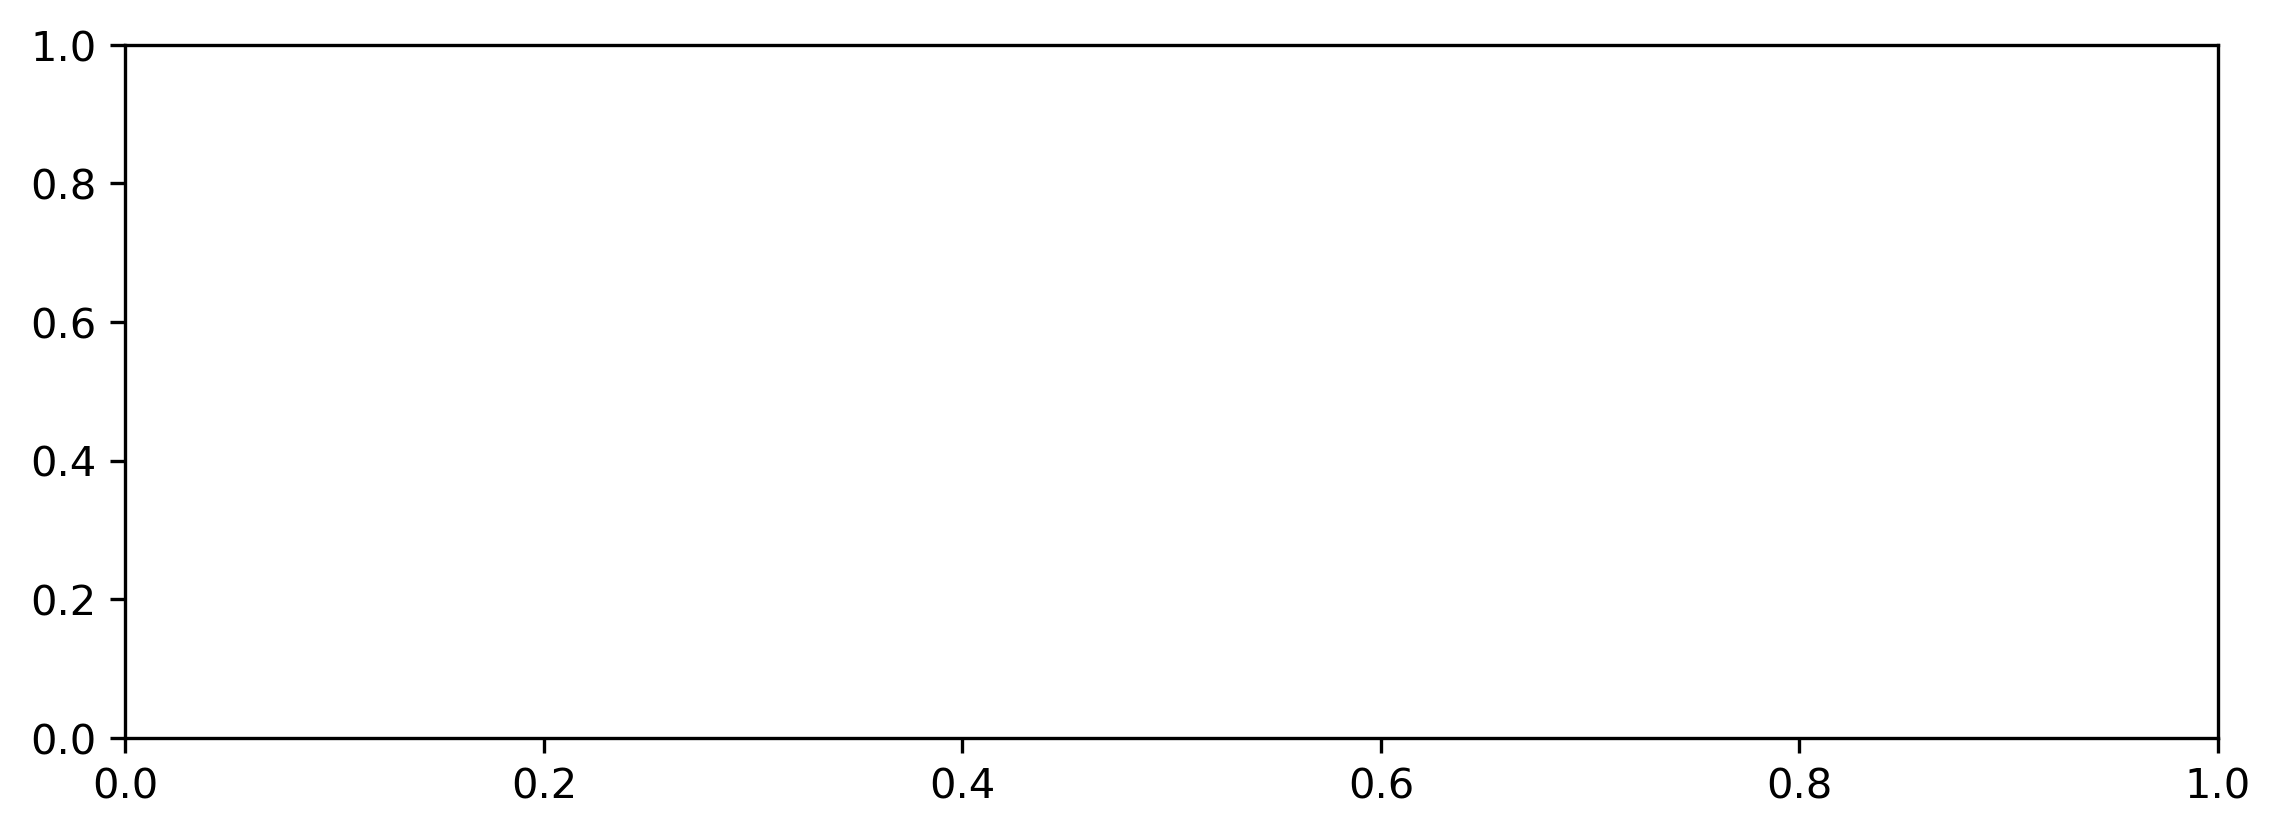

In [359]:
heatmap_2d(df, 'TIT')

In [355]:
sample.shape

(118, 17)

In [357]:
data.shape

(118, 17)

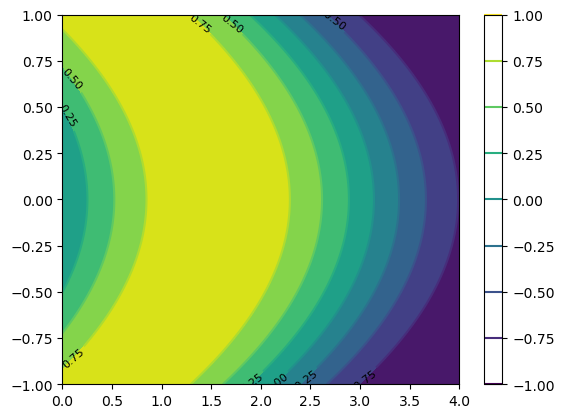

In [338]:
x = np.linspace(0, 4, 1000) # (1000, )
y = np.linspace(-1, 1, 1000) # (1000, )
xx, yy = np.meshgrid(x, y) # (1000, 1000)
z = np.sin(xx + yy**2) # (1000, 1000)
plt.figure()

CS = plt.contourf(x, y, z)
CS = plt.contour(x, y, z)
plt.clabel(CS, fontsize=8, colors='black')
cbar = plt.colorbar(CS)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\User\AppData\Local\Temp\ipykernel_772\4051425398.py:101: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


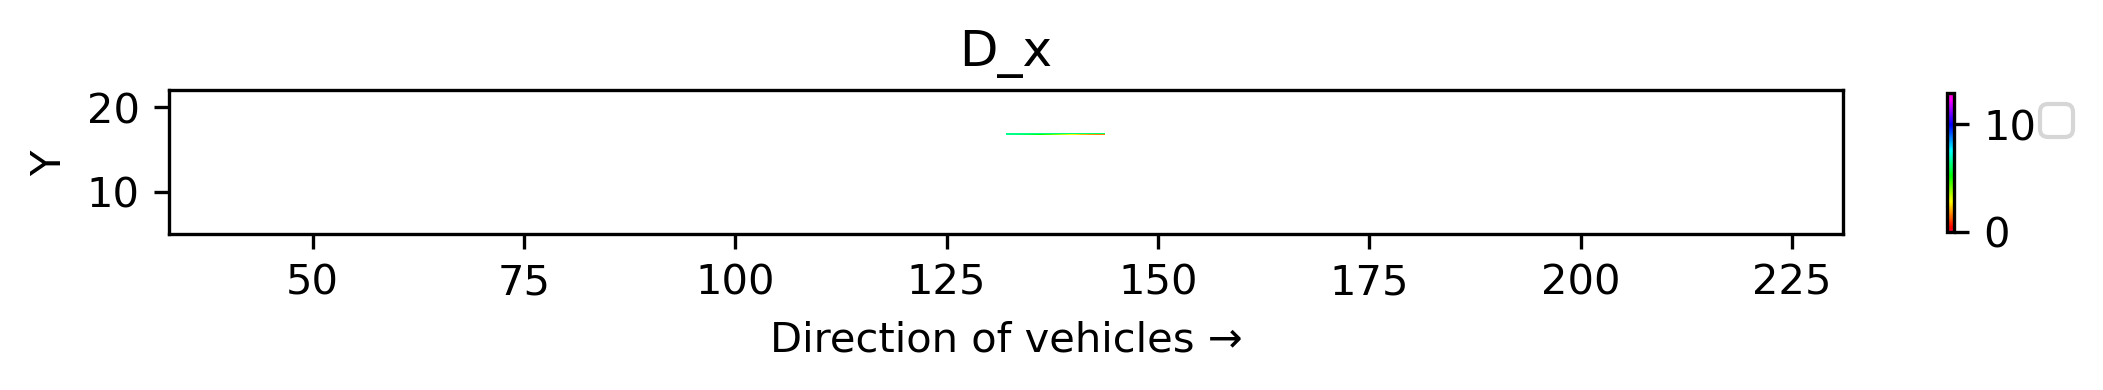

In [300]:
## 차로변경 차량

df2 = df.copy()
df2 = df[df['Lane_change'] == 'Change']

df2['X'] = df2['local_x'].apply(np.floor)
df2['Y'] = df2['local_y'].apply(np.floor)

sample = pd.pivot_table(df2, index = ['X'], columns = ['Y'], values = 'Lane_change', aggfunc = 'count')

x = np.array(df2['X'].unique())
y = np.array(df2['Y'].unique())
z = np.array(sample)

x = np.unique(x)
y = np.unique(y)

X, Y = np.meshgrid(x, y)
data = z

fig = plt.figure(figsize = (9, 3), dpi = 300)
ax = fig.add_subplot()

## 임계값 == 0이고, 임계값보다 크면 클수록 위험한 경우
if SSM in ['TIT', 'TIT2', 'ACTIT', 'TIDRAC', 'TIDSS', 'TERCRI', 'SSCR', 'TET', 'CI_MTTC']:
    TITnorm = colors.TwoSlopeNorm(vmin = 0, 
                                  vcenter = np.nanmean(sample), 
                                  vmax = np.nanmax([0.5, np.nanmax(sample)]))

    heat = ax.imshow(data, 
               aspect = 'equal', 
               norm = TITnorm,
               cmap = 'OrRd',
               extent = [min(x), max(x), min(y), max(y)] ) 
    
## 임계값이 존재하고, 값이 0 이상이며, 임계값보다 작을수록 위험한 경우
elif SSM in ['TTC', 'T2', 'MTTC', 'TA', 'ACT', 'PSD', 'pPET']:
    divnorm = colors.TwoSlopeNorm(vmin = 0, 
                                  vcenter = threshold, 
                                  vmax = 20)
    
    heat = ax.imshow(data, 
               aspect = 'equal', 
               norm = divnorm,
               cmap = 'RdBu',
               extent = [min(x), max(x), min(y), max(y)])
    
elif SSM in ['PICUD', 'DSS', 'MTC', 'MMTC']:
    divnorm = colors.TwoSlopeNorm(vmin = np.nanmin([-10, np.nanmin(sample)]), vcenter = threshold, vmax = np.nanmax([10, np.nanmax(sample)]))
    
    heat = ax.imshow(data, 
           aspect = 'equal', 
           norm = divnorm,
           cmap = 'RdBu',
           extent = [min(x), max(x), min(y), max(y)])
    
## 임계값이 있고, 임계값보다 클수록 위험한 경우
elif SSM in ['DRAC', 'MDRAC', 'DCIA', 'SSCR', 'RCRI', 'ITTC']:
    divnorm = colors.TwoSlopeNorm(vmin = np.nanmin(sample), vcenter = threshold, vmax = threshold + 5)
    
    heat = ax.imshow(data, 
       aspect = 'equal', 
       norm = divnorm,
       cmap = 'coolwarm',
       extent = [min(x), max(x), min(y), max(y)])
    
elif SSM in ['D', 'D_x']:
    
    TITnorm = colors.TwoSlopeNorm(vmin = 0, 
                                  vcenter = np.nanmean(sample), 
                                  vmax = np.nanmax([0.5, np.nanmax(sample)]))

    heat = ax.imshow(data, 
               aspect = 'equal', 
               norm = TITnorm,
               cmap = 'gist_rainbow',
               extent = [min(x), max(x), min(y), max(y)] ) 

else:
    heat = ax.imshow(data, 
       aspect = 'equal', 
       vmin = np.nanmin(sample), vmax = np.nanmax(sample),
       cmap = 'turbo',
       extent = [min(x), max(x), min(y), max(y)])


# ## 차로변경(LC) 위치 찍기
# LC_right = df[(df['Lane_change'] == 'Change') & (df['Lane_change_direction'] == 'Right')]
# LC_left = df[(df['Lane_change'] == 'Change') & (df['Lane_change_direction'] == 'Left')]

# ax.scatter(LC_right['local_x'], LC_right['local_y'], s = 3, c = 'Black', marker = 'o', linewidth = 0.3, label = 'To Right')
# ax.scatter(LC_left['local_x'], LC_left['local_y'], s = 3, c = 'Black', marker = 'x', linewidth = 0.3, label = 'To Left')

ax.legend(bbox_to_anchor = (1.15, 1.05), fancybox = True)
ax.set_title(f'{SSM}', fontsize = 12)
ax.set_xlabel('Direction of vehicles →', fontsize = 10)
ax.set_ylabel('Y', fontsize = 10)

fig.colorbar(heat, ax = ax, shrink = 0.2)

fig.show()

(11.87540125, 241.98637574999998, 3.218195200000004, 23.221360800000003)

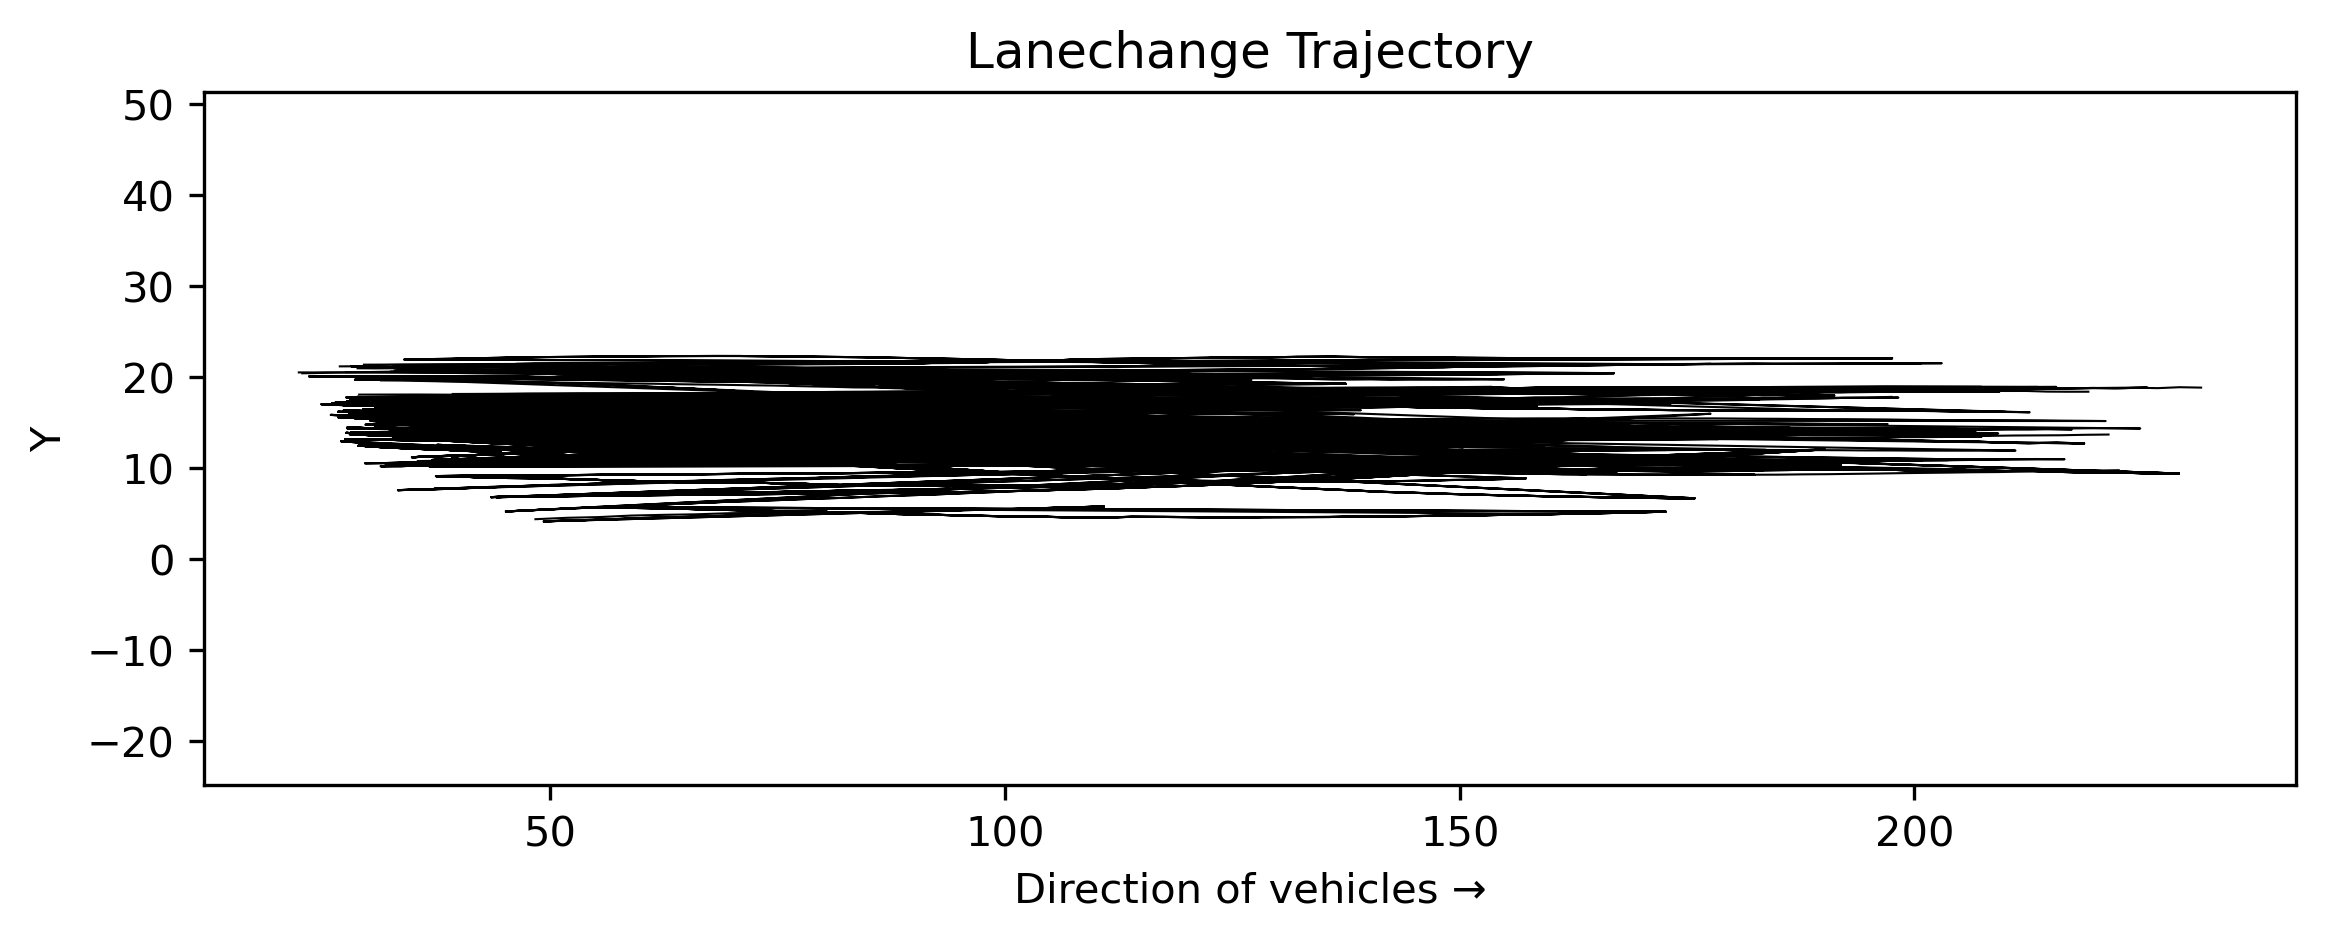

In [227]:
fig = plt.figure(figsize = (9, 3), dpi = 300)
ax = fig.add_subplot()

veh_list = np.array(df['Vehicle ID'].unique())

for veh in veh_list:

    sample = df[(df['Vehicle ID'] == veh) & (df['LC_CF'] == 'LC')]
    sample.reset_index(drop = True, inplace = True)
    sample.drop_duplicates(subset = 'Time')
    
    ax.plot(sample['local_x'], sample['local_y'], color = 'black', linewidth = 0.5)

ax.set_title(f'Lanechange Trajectory', fontsize = 12)
ax.set_xlabel('Direction of vehicles →', fontsize = 10)
ax.set_ylabel('Y', fontsize = 10)
ax.set_xlim([min(x), max(x)])
ax.set_ylim([min(y), max(y)])

ax.axis('equal')